In [1]:
import pandas as pd
pd.options.display.float_format = '{:,.1f}'.format
import numpy as np
import matplotlib.pyplot as plt
import dataframe_image as dfi
import six

In [2]:
#    ORIGINAL CSV FILE          UNIT          DESCRIPTION

#    timestamp                                Date with hours and minutes                  
#    TA                         degree C      air temperature (in Kelvin in CSV)
#    RH                         [0-1}         relative humidity
#    VW                         m/s           windspeed at 5 m above surface
#    DW                         degree        wind direction (degrees) - NOT USED
#    ISWR                       W/m^2         incoming short wave radiation 
#    OSWR                       W/m^2         reflected short wave radiation
#    ILWR                       W/m^2         incoming long wave radiation
#    OLWR                       W/m^2         outgoing long wave radiation
#    PSUM                       mm            undercatch corrected precipitation - NOT USED
#    HS_M                       cm            manually observed snow depth, once per day
#    HS                         cm            automatic measured snow depth - NOT USED
#    TSG                        degree K      ground temperature
#    TSS                        degree K      surface temperature
#    LYSI                       mm w.e.       snow lysimeter, measured snowpack runoff - NOT USED

In [3]:
# import meteo parameters of Weissfluhjoch
df_meteo = pd.read_csv('../DataSet_Meteo_Original_EnviDat/wfj_optimaldataset_v7.smet', skiprows=46, header=None, sep = ' ',
                   names = ['timestamp', 'TA', 'RH', 'VW', 'DW', 'ISWR', 'OSWR', 'ILWR', 'OLWR','PSUM',
                            'HS_M', 'HS','TSG', 'TSS', 'LYSI', 'SWE_M'])

# Rename columns
df_meteo.rename(columns = {'timestamp':'Date', 'HS_M':'Snow_height', 'TA': 'Temp', 'VW':'Wind'}, inplace = True)

# Drop unecessary columns
df_meteo.drop(columns = {'DW', 'HS', 'TSG', 'LYSI', 'PSUM', 'SWE_M'}, inplace = True) 
 
# Change the wind value to km/h unit
df_meteo['Wind'] = df_meteo['Wind'] * 3.6

# add NaN for -999 values
df_meteo = df_meteo.replace(to_replace = -999, value = np.nan)

# Convert Temperature value in degree Celsius
df_meteo['Temp'] = df_meteo['Temp'] - 273.15
df_meteo['TSS'] = df_meteo['TSS'] - 273.15

# convert column Date to datetime format
df_meteo['Date']= pd.to_datetime(df_meteo['Date'])

# Print df_meteo between 2 dates, as example of the data
start_date = "2017-03-02 07:00:00"
end_date = "2017-03-02 08:30:00"
after_start_date = df_meteo['Date'] >= start_date
before_end_date = df_meteo['Date'] <= end_date
between_two_dates = after_start_date & before_end_date
df_meteo.loc[between_two_dates]

,Date,Temp,RH,Wind,ISWR,OSWR,ILWR,OLWR,Snow_height,TSS
359388,2017-03-02 07:00:00,-4.9,1.0,1.4,1.7,0.6,280.5,288.8,nan,-6.3
359389,2017-03-02 07:30:00,-4.6,1.0,3.2,15.1,12.8,281.3,289.8,nan,-6.1
359390,2017-03-02 08:00:00,-4.2,1.0,1.4,68.8,60.6,286.2,294.0,145.0,-5.2
359391,2017-03-02 08:30:00,-3.8,1.0,2.5,78.6,70.0,288.7,295.2,nan,-4.9


In [4]:
# Create separate df to calculate the snow fall value of the last day and of the last 3 days
Snow_Height = df_meteo.copy()
Snow_Height = Snow_Height[['Date', 'Snow_height']]

# The snow depth is measured every day in the morning between 00:00 and 11:00, so the other rows are removed
Snow_Height = Snow_Height[(Snow_Height['Date'].apply(lambda x : x.hour)>0) & (Snow_Height['Date'].apply(lambda y : y.hour)<11)]

# The snow depth is measured every day in the morning between 06:00 and 08:00, so the other rows are removed
#Snow_Height = Snow_Height[(Snow_Height['Date'].apply(lambda x : x.hour)>5) & (Snow_Height['Date'].apply(lambda y : y.hour)<9)]

# calculate the snow fall value of the last day and of the last 3 days
Snow_Height = Snow_Height[(Snow_Height["Snow_height"].apply(lambda x : x >= 0))]
Snow_Height = Snow_Height.set_index('Date')
Snow_Height = Snow_Height.resample('1D').agg({'Snow_height': np.mean})

Snow_Height

,Snow_height
Date,
1996-09-01,1.0
1996-09-02,0.0
1996-09-03,0.0
1996-09-04,0.0
1996-09-05,0.0
...,...
2017-06-27,0.0
2017-06-28,0.0
2017-06-29,1.0


In [5]:
# Resample the meteo parameter to one day in calculating the mean of each variable
df_meteo = df_meteo.set_index('Date')
df_meteo['Temp_min'] = df_meteo['Temp']
df_meteo['Temp_max'] = df_meteo['Temp']
df_meteo['Wind_max'] = df_meteo['Wind']
df_meteo = df_meteo.resample('1D').agg({'Temp': np.mean, 'Temp_min': np.min, 'Temp_max': np.max, 'RH': np.mean, 'ISWR':np.mean, 'OSWR':np.mean,
                                        'ILWR':np.mean, 'OLWR':np.mean, 'TSS':np.mean, 'Wind':np.mean, 'Wind_max':np.max})
# Join the Snow Height information with the meteo parameters
df_meteo = pd.concat([df_meteo, Snow_Height], axis = 1, sort = False)
df_meteo['Snow_height'] = df_meteo.Snow_height.fillna(0)

# Create new column with snow fall height of the last day: Snow_fall_1
df_meteo['Snow_fall_1'] = df_meteo['Snow_height'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])

# Change Snow_fall_1 to type float and set negative value to zero
temp = df_meteo['Snow_fall_1'] > 0
df_meteo['Snow_fall_1'] = df_meteo['Snow_fall_1'] * temp
    
# Create new column with snow fall height sum of the day
df_meteo['Snow_fall'] = df_meteo['Snow_fall_1'].shift(-1)

# Create separate column to have the mean temp of the last day
df_meteo['Temp_mean_1'] = df_meteo['Temp'].shift(periods=1)

# Create separate column to have the min temp of the last day and of the last 3 days
df_meteo['Temp_min_1'] = df_meteo['Temp_min'].shift(periods=1)
df_meteo['Temp_min_3'] = df_meteo['Temp_min_1'].rolling(window=3).min()

# Create separate column to have the mean wind of the last day
df_meteo['Wind_mean_1'] = df_meteo['Wind'].shift(periods=1)

# Create separate column to have the max wind of the last day and of the last 3 days
df_meteo['Wind_max_1'] = df_meteo['Wind_max'].shift(periods=1)
df_meteo['Wind_max_3'] = df_meteo['Wind_max_1'].rolling(window=3).max()

# Create new columnt with information if Snow_fall_1 is below or above 25cm
df_meteo['Snow10To25'] = df_meteo['Snow_fall_1'].apply(lambda x : 10 < x <= 25)
df_meteo['SnowAbove25'] = df_meteo['Snow_fall_1'].apply(lambda x : x > 25)

df_meteo['Snow10To25_on_the_day'] = df_meteo['Snow_fall'].apply(lambda x : 10 < x <= 25)
df_meteo['SnowAbove25_on_the_day'] = df_meteo['Snow_fall'].apply(lambda x : x > 25)

df_meteo['Snow10To25'] = df_meteo['Snow10To25'] | df_meteo['Snow10To25_on_the_day']
df_meteo['SnowAbove25'] = df_meteo['SnowAbove25'] | df_meteo['SnowAbove25_on_the_day']

# add the criteria for Unfavorable conditions in the df_meteo
# a remettre  df_meteo['WindAbove40'] = df_meteo['Wind_max_mean_3'].apply(lambda x : x > 40)
df_meteo['WindAbove40'] = df_meteo['Wind_max_3'].apply(lambda x : x > 40)
# a remettre  df_meteo['TempBelow-5'] = df_meteo['Temp_min_mean_3'].apply(lambda x : x < -5)
df_meteo['TempBelow-7_5'] = df_meteo['Temp_min_1'].apply(lambda x : x < -7.5)

# Calculate for which day the condition "NewSnowProblem" is true
df_meteo['NewSnowProblem'] = df_meteo.SnowAbove25.astype(int) | (df_meteo.Snow10To25.astype(int) & (df_meteo.WindAbove40.astype(int) | df_meteo['TempBelow-7_5'].astype(int)))

# a remettre  df_meteo['NewSnowProblemB'] = df_meteo.SnowAbove25B.astype(int) | (df_meteo.Snow10To25B.astype(int) & (df_meteo.WindAbove40.astype(int) | df_meteo['Temp'].astype(int)))
# a remettre  df_meteo['NewSnowProblem'] = df_meteo['NewSnowProblemB'] | df_meteo['NewSnowProblem']

# Keep the used columns
df_meteo = df_meteo[['Snow_fall','Snow_fall_1','Snow10To25','SnowAbove25','Temp_min_1','TempBelow-7_5',
                     'Wind_max_3','WindAbove40','NewSnowProblem',
                     'Temp', 'Temp_mean_1', 'Temp_min', 'Temp_min_3', 'Temp_max',
                     'Wind', 'Wind_mean_1', 'Wind_max', 'Wind_max_1',
                     'Snow_height', 'RH', 'ISWR', 'OSWR', 'ILWR', 'OLWR', 'TSS']]

df_meteo = df_meteo.dropna()

df_meteo['Snow_fall'] = df_meteo['Snow_fall'].astype(int)
df_meteo['Snow_fall_1'] = df_meteo['Snow_fall_1'].astype(int)

Text(0.5, 1.0, 'Histogram - Temperature')

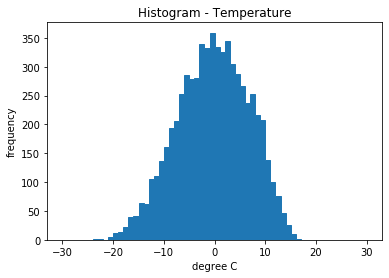

In [6]:
# Plot the histogram of the variable "Temperature"
fig, ax = plt.subplots()
plt.hist(df_meteo['Temp'],fill=True,histtype='step',  bins=60,range=(-30,30))
ax.set_xlabel('degree C')
ax.set_ylabel('frequency')
ax.set_title('Histogram - Temperature')

In [7]:
# Describre the variable "Temperature"
df_meteo['Temp'].describe()

count   6,479.0
mean       -0.4
std         7.0
min       -23.7
25%        -5.3
50%        -0.2
75%         4.9
max        16.4
Name: Temp, dtype: float64

Text(0.5, 1.0, 'Histogram - Snow fall of the last day')

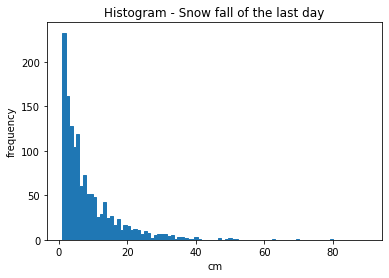

In [8]:
# Plot the histogram of the variable "Snow fall of the last day"
fig, ax = plt.subplots()
plt.hist(df_meteo['Snow_fall_1'],fill=True,histtype='step',  bins=90, range = (1,90))
ax.set_xlabel('cm')
ax.set_ylabel('frequency')
ax.set_title('Histogram - Snow fall of the last day')

In [9]:
# Describe the variable:  "Snow fall of the last day"
df_meteo['Snow_fall_1'].describe()

count   6,479.0
mean        1.7
std         5.2
min         0.0
25%         0.0
50%         0.0
75%         0.0
max        80.0
Name: Snow_fall_1, dtype: float64

Text(0.5, 1.0, 'Histogram - Mean wind')

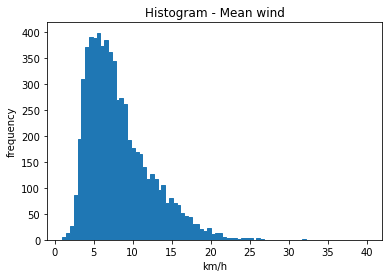

In [10]:
# Plot the histogram of the variable "Wind" (Mean wind of the day)
fig, ax = plt.subplots()
plt.hist(df_meteo['Wind'],fill=True,histtype='step', bins=80,range=(1,40))
ax.set_xlabel('km/h')
ax.set_ylabel('frequency')
ax.set_title('Histogram - Mean wind')

In [11]:
# Describe the variable:  "Wind" (Mean wind of the day)
df_meteo['Wind'].describe()

count   6,479.0
mean        8.2
std         4.0
min         0.0
25%         5.2
50%         7.2
75%        10.3
max        32.1
Name: Wind, dtype: float64

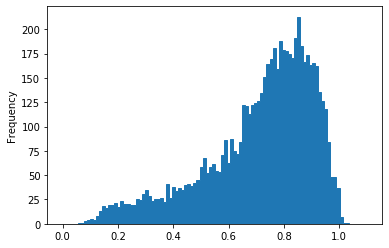

In [12]:
# Plot the histogram of the variable "Relative Humidity"
df_meteo['RH'].plot(kind="hist",fill=True,histtype='step', bins=100,range=(0,1.1))

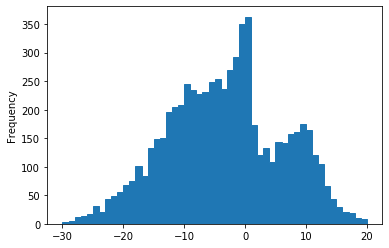

In [13]:
# Plot the histogram of the variable "Surface temperature of the snow"
df_meteo['TSS'].plot(kind="hist",fill=True,histtype='step', bins = 50, range=(-30,20))

In [14]:
#    Processed_meteo_data.csv
#    DF_METEO                    UNIT          DESCRIPTION

#    Date                                      Date
#    Snow_fall                   cm            Snow fall sum of the day
#    Snow_fall_1                 cm            Snow fall sum of the last day
#    Snow10To25                  True/false    Snow_fall_3 between 10cm and 25cm
#    SnowAbove25                 True/false    Snow_fall_3 above 25cm
#    Temp_min_1                  degree C      Minimum of temperature of the last day
#    TempBelow7_5                True/false    Temp_min_1 below -7.5 degree
#    Wind_max_3                  km/h          Maximum of the mean wind of the last 3 days
#    WindAbove40                 True/false    Wind_max_3 above 40km/h
#    NewSnowProblem              1 or 0        New Snow Prolem condition = 1, other snow conditions = 0
#    Temp                        degree C      Air temperature (mean of the day)
#    Temp_mean_1                 degree C      Mean temperature of the last day
#    Temp_min                    degree C      Minimum of temperature of the day
#    Temp_min_3                  degree C      Minmean temperature of the last 3 days
#    Temp_max                    degree C      Maximum of temperature of the day
#    Wind                        km/h          Wind speed (mean of the day)
#    Wind_mean_1                 km/h          Mean wind of the last day
#    Wind_max                    km/h          Maximum wind of the day
#    Wind_max_1                  km/h          Maximum wind of the last day
#    Snow_height                 cm            Snow height measured at 08h00
#    RH                          [0-1}         relative humidity
#    ISWR                        W/m^2         incoming short wave radiation 
#    OSWR                        W/m^2         reflected short wave radiation
#    ILWR                        W/m^2         incoming long wave radiation
#    OLWR                        W/m^2         outgoing long wave radiation
#    TSS                         degree C      Snow surface temperature

In [15]:
# Write df to csv file
df_meteo.to_csv('../Processed_DataSets/Meteo.csv')

# Print df_meteo between 2 dates, as example of the data
Print_df = df_meteo.reset_index()
start_date = "2017-03-02"
end_date = "2017-03-13"
after_start_date = Print_df['Date'] >= start_date
before_end_date = Print_df['Date'] <= end_date
between_two_dates = after_start_date & before_end_date
Print_df.loc[between_two_dates]

,Date,Snow_fall,Snow_fall_1,Snow10To25,SnowAbove25,Temp_min_1,TempBelow-7_5,Wind_max_3,WindAbove40,NewSnowProblem,...,Wind_mean_1,Wind_max,Wind_max_1,Snow_height,RH,ISWR,OSWR,ILWR,OLWR,TSS
6348,2017-03-02,0,0,False,False,-12.0,True,31.3,False,0,...,7.2,17.6,19.8,145.0,0.9,117.9,106.0,249.5,280.5,-8.4
6349,2017-03-03,0,0,False,False,-7.8,True,23.0,False,0,...,7.1,26.6,17.6,144.0,0.6,135.9,115.6,237.9,280.3,-8.6
6350,2017-03-04,10,0,False,False,-8.4,True,26.6,False,0,...,13.3,29.9,26.6,139.0,0.9,135.3,115.2,237.9,287.8,-6.8
6351,2017-03-05,11,10,True,False,-7.1,False,29.9,False,0,...,20.8,17.6,29.9,149.0,1.0,148.2,130.3,258.4,278.7,-8.7
6352,2017-03-06,15,11,True,False,-8.4,True,29.9,False,1,...,5.6,19.4,17.6,160.0,0.9,137.6,120.7,260.7,277.8,-9.0
6353,2017-03-07,0,15,True,False,-10.2,True,29.9,False,1,...,6.5,26.6,19.4,175.0,1.0,173.0,157.1,265.5,272.9,-10.0
6354,2017-03-08,23,0,True,False,-10.8,True,26.6,False,1,...,15.8,7.6,26.6,169.0,0.8,169.4,145.2,243.2,270.7,-9.2
6355,2017-03-09,13,23,True,False,-13.6,True,26.6,False,1,...,3.4,21.2,7.6,192.0,1.0,93.4,87.6,303.8,305.5,-2.5
6356,2017-03-10,0,13,True,False,-3.5,False,26.6,False,0,...,9.0,26.3,21.2,205.0,0.9,220.2,189.9,229.9,280.5,-8.3
6357,2017-03-11,0,0,False,False,-8.3,True,26.3,False,0,...,13.9,11.9,26.3,198.0,0.2,216.6,178.1,211.5,269.1,-11.0
